## Dataset

In [1]:
# Load required libraries 
import os
import math
from numpy import * 
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

# Libraries for Machine Learning
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.model_selection import GridSearchCV # import GridSearchCV
import xgboost as xgb  
from xgboost import  XGBClassifier
import warnings
warnings.filterwarnings("ignore") # suppress all warnings

# Libraries for ML pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## 1. Load Data

In [2]:
df = pd.read_csv("dataset/transaction_dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


The target variable

Variable types (categorical and numerical)

Numerical variables
    Discrete
    Continuous
    Distributions
    Transformations

Categorical variables
    Cardinality
    Rare Labels
    Special mappings

In [3]:
# Examine the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Examine the summary statistics of the columns
df.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

In [5]:
df.shape

(6362620, 11)

In [6]:
# Check missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Check duplication
df.duplicated().sum()

0

## 2. EDA

Text(0.5, 1.0, 'Distribution of Transactions over Period')

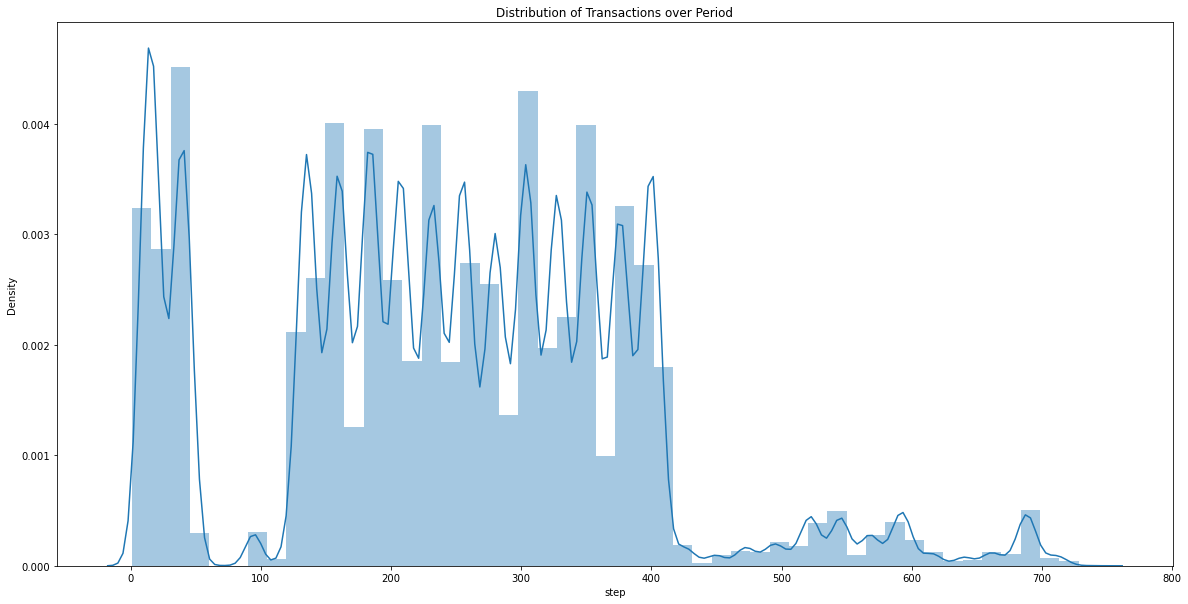

In [8]:
# Distribution of the frequency of all transactions
plt.figure(figsize=(20, 10))
sns.distplot(df.step)
plt.title('Distribution of Transactions over Period')

The distribution plot shows how many transactions happened in each hour. The amount of transactions changes a lot over time.

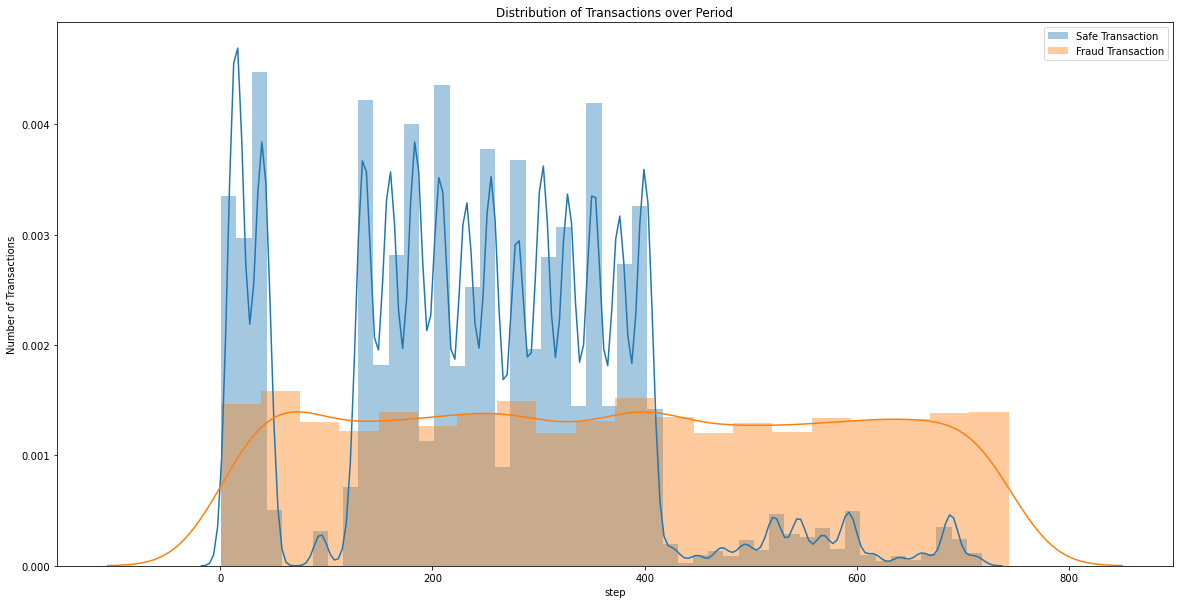

In [9]:
# Check the frequency of the transactions for each class
s = df[df['isFraud']==0]
f = df[df['isFraud']==1]

plt.figure(figsize=(20, 10))
plt.title('Distribution of Transactions over Period')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
sns.distplot(s.step, label="Safe Transaction")
sns.distplot(f.step, label='Fraud Transaction')
plt.legend()

Even though secure transactions become slower on the 3rd and 4th day, and after the 16th day of the month, fraudulent transactions still happen at a regular rate. In the last part of the month, there are not as many secure transactions, but the amount of fraudulent transactions stays the same.

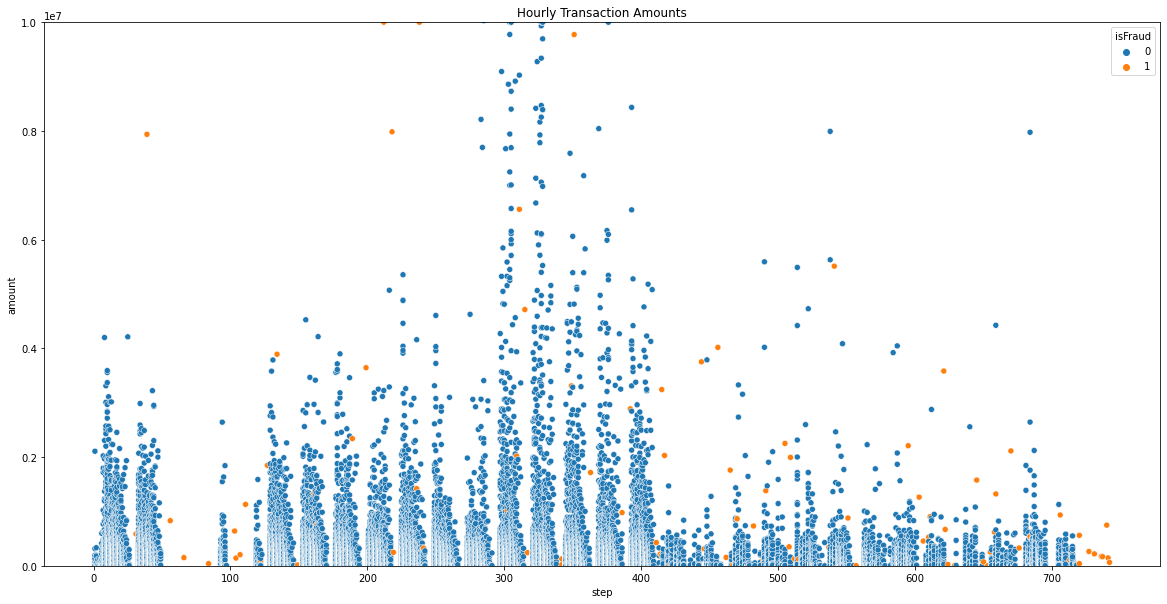

In [10]:
portion_data=df.sample(n=100000, random_state=1)
portion_data=portion_data.sort_index()
portion_data=portion_data.reset_index(drop=True)

#plot the small data
plt.figure(figsize=(20,10))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", hue="isFraud",
                     data=portion_data)

The graph shows that more transactions happen at certain times of the day. We notice a repeating cycle every day that takes 24 hours. We are not sure which part of the day "0" means, but we can see that most transactions happen in the middle of the day. It could be either noon or in the middle of the day. Let's check if fake transactions have a specific pattern.

<AxesSubplot:title={'center':'Safe Transaction Amount Distribution'}, xlabel='amount', ylabel='Density'>

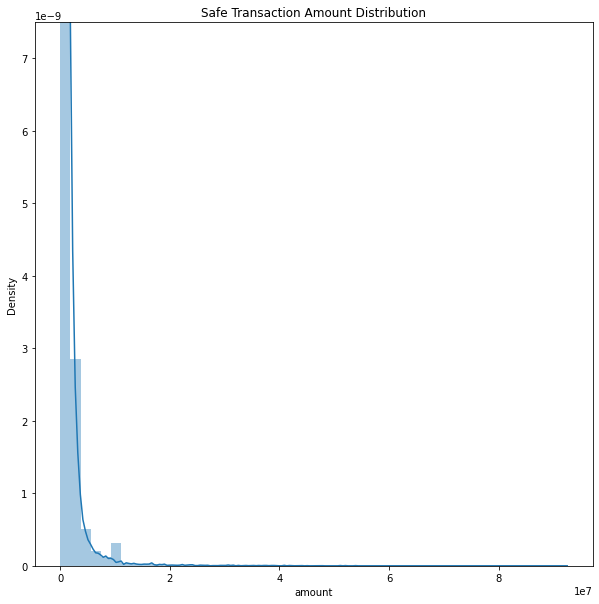

In [11]:
# Safe transactions amount distribution plot
plt.figure(figsize=(10,10))
plt.ylim(0, 0.0000000075)
plt.title('Safe Transaction Amount Distribution')
sns.distplot(s.amount)

<AxesSubplot:title={'center':'Fraud Transaction Amount Distribution'}, xlabel='amount', ylabel='Density'>

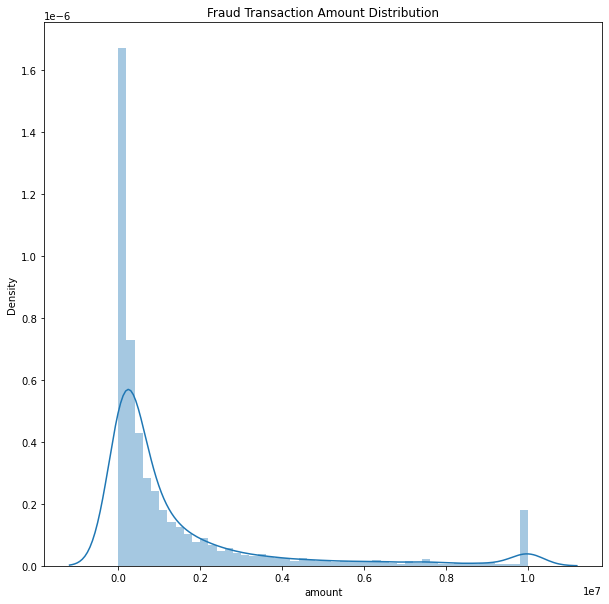

In [12]:
# Fraud transactions amount distribution plot
plt.figure(figsize=(10,10))
plt.title('Fraud Transaction Amount Distribution')
sns.distplot(f.amount)

In [13]:
# fraud transactions amount value counts
f.amount.value_counts()

10000000.00    287
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
149668.66        1
7316255.05       1
222048.71        1
9585040.37       1
234377.29        1
Name: amount, Length: 3977, dtype: int64

Appreantly, the fraud trasactions in $1M has been appeared 287 times which is the max amount for fraud transactions.

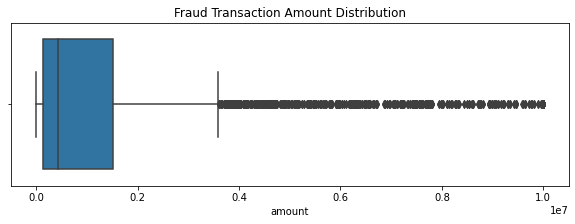

In [14]:
# Boxplot for Fraud transaction boxplot for amount distribution
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
ax = sns.boxplot(x=f["amount"])

In [15]:
f.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

Most of the frauds happens below $400000 so lets check the average amount for those transactions.

In [16]:
#average amount for frauds below 400K
f[f.amount<400000].amount.mean()

144912.16828933996

In [17]:
# checking tpye of safe transactions
s.type.value_counts()

CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

Fraud activities only happens with transfer and cash_out transactions. Debit usage is very safe. It will be better to use only Transfer and Cash_out transaction data for our model since the other types has no fraud.

In [18]:
# checking type of fraud transactions
f.type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [19]:
# Filter data by the labels. Safe and Fraud transaction
fraud = df[df['isFraud']==0]
safe = df[df['isFraud']==1]

Fraud_Num = round(df['isFraud'].value_counts()[0]/len(df)*100,3)
Safe_Num = round(df['isFraud'].value_counts()[1]/len(df)*100,3)


print("Number of Safe Values :  ",df['isFraud'].value_counts()[1])
print("Number of Fraud Values : ",df['isFraud'].value_counts()[0])
print("\n")
print("Percentage of Fraud transactions :  \t", Fraud_Num)
print("Percentage of Non-Fraud transactions :  ", Safe_Num)

Number of Safe Values :   8213
Number of Fraud Values :  6354407


Percentage of Fraud transactions :  	 99.871
Percentage of Non-Fraud transactions :   0.129


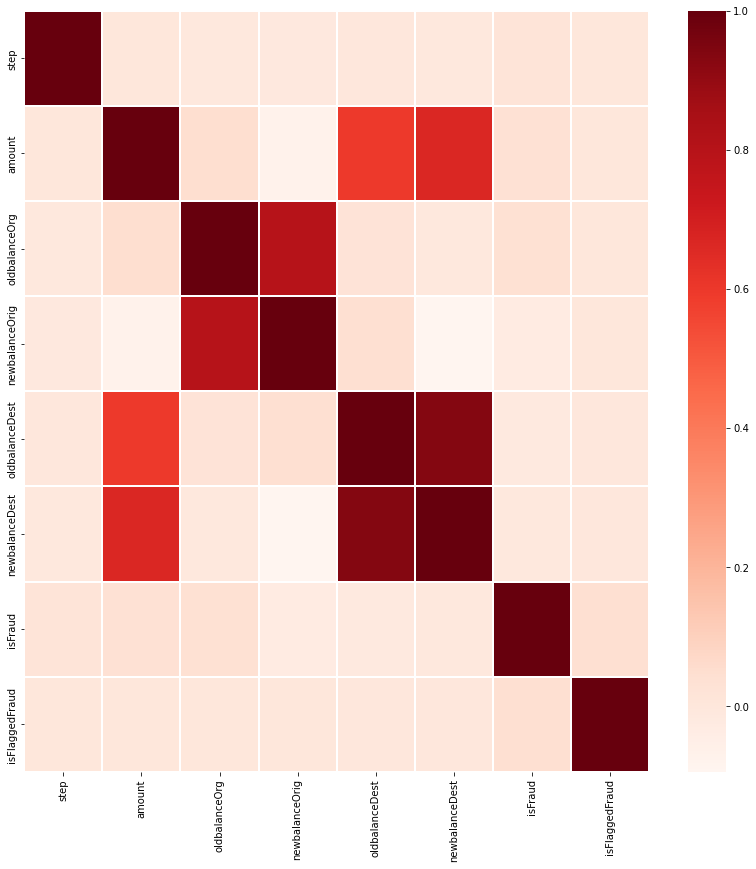

In [20]:
# Plot and visualize the correlation between attributes
plt.figure(figsize=(14,14))
corr = df.corr(method = 'spearman')
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, linewidths=.1, cmap="Reds", annot = False)
plt.show()

In [21]:
# Determine number of fraud cases in the dataset
Outlier_Fraction = (fraud/(safe+fraud)) * 100
# Valid transaction if Class = 0 and Fraud if Class = 1
fraud = len(df[df['isFraud'] == 0])
safe = len(df[df['isFraud'] == 1])

print('The outlier fraction is :' , Outlier_Fraction) 
print('The safe transactions are :'  , safe ) 
print('The fraud transactions are :'  , fraud )

The outlier fraction is :          step type  amount nameOrig  oldbalanceOrg  newbalanceOrig nameDest  \
0         NaN  NaN     NaN      NaN            NaN             NaN      NaN   
1         NaN  NaN     NaN      NaN            NaN             NaN      NaN   
2         NaN  NaN     NaN      NaN            NaN             NaN      NaN   
3         NaN  NaN     NaN      NaN            NaN             NaN      NaN   
4         NaN  NaN     NaN      NaN            NaN             NaN      NaN   
...       ...  ...     ...      ...            ...             ...      ...   
6362615   NaN  NaN     NaN      NaN            NaN             NaN      NaN   
6362616   NaN  NaN     NaN      NaN            NaN             NaN      NaN   
6362617   NaN  NaN     NaN      NaN            NaN             NaN      NaN   
6362618   NaN  NaN     NaN      NaN            NaN             NaN      NaN   
6362619   NaN  NaN     NaN      NaN            NaN             NaN      NaN   

         oldbalanceDest  

## 2. Feature Engineering

Since fraud transactions happens only in "TRANSFER" and "CASH_OUT". Hence, we will use those data. Since the data is too big to work with a machine learning algorithm. We will start with 100000 random samples from the dataframe to ensure it is big enough to build the machine learning models.

In [22]:
# Filiter data only in "TRANSFER" and "CASH_OUT"
data_type = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Get 100000 random sample to train model
dt = data_type.sample(n = 100000, random_state = 1)
dt=dt.sort_index()
dt=dt.reset_index(drop=True)
dt.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.00,0.00,0,0
1,1,TRANSFER,367768.40,C288306765,0.00,0.00,C1359044626,370763.10,16518.36,0,0
2,1,CASH_OUT,81029.86,C324112183,0.00,0.00,C288665596,105343.00,8496.61,0,0
3,1,CASH_OUT,53631.83,C1233595751,0.00,0.00,C757108857,83244.00,0.00,0,0
4,1,CASH_OUT,365510.05,C1299327689,0.00,0.00,C564160838,564572.76,1254956.07,0,0


### Name Columns
The data column "nameOrig" and "nameDest" are the names of the people. Since there's no repeated transaction between two parties, which means each transaction is unique. Therefore, we can just drop those columns.

In [23]:
# Drop the name columns
dt=dt.drop(['nameOrig', 'nameDest'], axis = 1)

# Use binary-encoding to label data in 'type'
dt.loc[dt.type == 'CASH_OUT', 'type'] = 1
dt.loc[dt.type == 'TRANSFER', 'type'] = 0
dt.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,136872.92,162075.98,25203.05,217806.00,0.00,0,0
1,1,0,367768.40,0.00,0.00,370763.10,16518.36,0,0
2,1,1,81029.86,0.00,0.00,105343.00,8496.61,0,0
3,1,1,53631.83,0.00,0.00,83244.00,0.00,0,0
4,1,1,365510.05,0.00,0.00,564572.76,1254956.07,0,0


In [24]:
dt.type

0        1
1        0
2        1
3        1
4        1
        ..
99995    1
99996    0
99997    1
99998    0
99999    0
Name: type, Length: 100000, dtype: object

## 3. Machine Learning


# Libraries for Machine Learning
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.model_selection import GridSearchCV # import GridSearchCV
import xgboost as xgb  
from xgboost import  XGBClassifier
import warnings
warnings.filterwarnings("ignore") # suppress all warnings

In [25]:
#from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Iterate over column names
for column in dt:
    if dt[column].dtype.kind == 'O':
        dt[column]= label_encoder.fit_transform(dt[column])
        dt[column]= label_encoder.fit_transform(dt[column]) 

In [26]:
# Slice the target and features from the dataset
features = dt.drop('isFraud', axis=1)
target = dt.isFraud

In [27]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

## 3.1 Baseline Models

In this section, we'll run five different classification models with default parameter to determine the whch one has the best result. All of the classifiers wiuld be into a list and train continuly. 

In [28]:
def ml_fun(algo):
    # Train and train regression models
    model = algo()
    model.fit(X_train, y_train)

    # Predict
    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)

    # Evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy  = roc_auc_score(y_test, test_preds)
    
    # Display result
    print(str(algo))
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("----------------------------------------------------------------------")
    
    score_logreg = [algoritm, train_accuracy, test_accuracy]
    models = pd.DataFrame([score_logreg])

In [29]:
#list of all classifiers that I will run for base models 
algoritms=[LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, svm.SVC]

#running each model and print accuracy scores
for algoritm in algoritms:
    ml_fun(algoritm)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Training Accuracy: 75.95%
Test Accuracy:     78.74%
----------------------------------------------------------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Training Accuracy: 83.32%
Test Accuracy:     83.89%
----------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Training Accuracy: 99.77%
Test Accuracy:     83.9%
----------------------------------------------------------------------
<class 'xgboost.sklearn.XGBClassifier'>
Training Accuracy: 100.0%
Test Accuracy:     86.44%
----------------------------------------------------------------------
<class 'sklearn.svm._classes.SVC'>
Training Accuracy: 63.01%
Test Accuracy:     59.32%
----------------------------------------------------------------------


## 3.2 Gred Search for Best Parameter


In the above report, we see that the best training accurary is XGBClasifier. The second best test accuracy is Random Forest Classifier. Therefore, We will optimize these two model with grid search of multiple parameter values by using grid search. It will help to determine the best parameter to pass to the model to get the most accurate result. We will create a function to take parameter values and the classifier and print out the best parameter combinations.

In [30]:
def grid_src(classifier, param_grid):
    param_grid=param_grid
    
    # Instantiate the tuned random forest
    grid_search = GridSearchCV(classifier, param_grid, cv = 3, n_jobs =- 1)

    # Train the tuned random forest
    grid_search.fit(X_train, y_train)

    # Display the best estimator parameters found during the grid search
    print((str(classifier) + 'Best Parameters'))
    print("------------------------")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [31]:
#Grid Search for best parameters of RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 80, 100],
                  'criterion': ['gini', 'entropy'],         
                  'max_depth': [10], 
                  'min_samples_split': [2, 3, 4]
                 }

rf_params=grid_src(RandomForestClassifier(),param_grid_rf)

RandomForestClassifier()Best Parameters
------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 80}


In [32]:
#Grid Search for best parameters of XGBClassifier
param_grid_xg = {'n_estimators': [100],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 10],
              'colsample_bytree': [0.7, 1],
              'gamma': [0.0, 0.1, 0.2]
                }
grid_src(XGBClassifier(), param_grid_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)Best Parameters
------------------------
{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 100}

### Run models with their best parameters

In [33]:
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # Predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Evaluate
    train_acc = roc_auc_score(y_train, train_preds)
    test_acc = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)

    # Print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
    print(f"Training Accuracy: {(train_acc * 100):.4}%")
    print(f"Test Accuracy:     {(test_acc * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)

In [34]:
# Running RandomForestClassifier with best parameters
rf_model = RandomForestClassifier(n_estimators=100, 
                                  criterion= 'gini', 
                                  max_depth= 10, 
                                  min_samples_split= 3)
                               
                               
run_model(rf_model, X_train, y_train, X_test, y_test)

Model Scores
------------------------
Training Accuracy: 85.84%
Test Accuracy:     83.9%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19941
           1       1.00      0.68      0.81        59

    accuracy                           1.00     20000
   macro avg       1.00      0.84      0.90     20000
weighted avg       1.00      1.00      1.00     20000



The accuracy decreased when I adjusted the max_depth to 10, as this value acts as a cutoff for the model, causing it to stop growing beyond that depth. By default, the model has unlimited depth, leading to higher accuracy as it continues growing until all leaves reach the purest level. However, for large datasets, this can become time-consuming. Despite the drop in accuracy, I will retain this parameter and focus on further improvements 

In [35]:
# Running KNeighbors Classifier with best parameters
# Running XGBClassifier with best parameters
xgb_model=XGBClassifier(colsample_bytree= 1, 
                        n_estimators= 100,
                        gamma= 0.1,
                        learning_rate=0.1,
                        max_depth=5
                        )
                                                                 
run_model(xgb_model, X_train, y_train, X_test, y_test)

Model Scores
------------------------
Training Accuracy: 92.01%
Test Accuracy:     85.59%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19941
           1       1.00      0.71      0.83        59

    accuracy                           1.00     20000
   macro avg       1.00      0.86      0.92     20000
weighted avg       1.00      1.00      1.00     20000



From the result, XGBoost has higher accuracy than Random Forest Classifier with the best parameters set. One of the possibilities is it might effected the skewness of the target and we find out that the data is heavily unbalanced. In the next steps, we will resampling the data with SMOTE.

## 3.3 Handling Unbalnaced Data
### 3.3.1 Balancing Data with oversampling with SMOTE

In [36]:
#from imblearn.over_sampling import SMOTE

# Display previous class distribution
print(target.value_counts()) 

# resample data ONLY using training data
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train) 

# Display synthetic sample class distribution
print(pd.Series(y_resampled).value_counts()) 

0    99722
1      278
Name: isFraud, dtype: int64
0    79781
1    79781
Name: isFraud, dtype: int64


In [37]:
# Split train and test over resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

### Running models with the balanced data to find the best parameters

In [38]:
# Run Random Forest Model with resampled data
run_model(rf_model, X_train, y_train, X_test, y_test)

Model Scores
------------------------
Training Accuracy: 99.16%
Test Accuracy:     99.09%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19765
           1       0.99      1.00      0.99     20126

    accuracy                           0.99     39891
   macro avg       0.99      0.99      0.99     39891
weighted avg       0.99      0.99      0.99     39891



In [39]:
# Running XGBoost Model with resampled data
run_model(xgb_model, X_train, y_train, X_test, y_test)

Model Scores
------------------------
Training Accuracy: 99.65%
Test Accuracy:     99.66%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     19765
           1       0.99      1.00      1.00     20126

    accuracy                           1.00     39891
   macro avg       1.00      1.00      1.00     39891
weighted avg       1.00      1.00      1.00     39891



The performance of both models had changed drmatically due to synthetic data performed by SMOTE. SMOTE can created an excessive amount of similar data points, which causing the model to memorize these patterns and getting better results on the test set.

### 3.3.2 Subsampling Data from Orginial Dataset

In [53]:
# Filter the only types that fraud transaction occurs
data2=df[df['type'].isin(['TRANSFER','CASH_OUT'])]

# Slice data in to fraud and safe by isFraud values
safe_2 = data2[data2['isFraud']==0]
fraud_2 = data2[data2['isFraud']==1]

# Extract 50000 random sample from the safe transactions 
sample1=safe_2.sample(n=50000, random_state=1)
sample1=sample1.sort_index()
sample1=sample1.reset_index(drop=True)

# Combine all fraud observation and 50000 safe transaction data
df3=pd.concat([sample1,fraud_2])
df3.reset_index(drop=True)

# Remove name columns
df3=df3.drop(['nameOrig', 'nameDest'], axis=1)

# Binary-encoding of labelled data in 'type'
df3.loc[df3.type == 'CASH_OUT', 'type'] = 1
df3.loc[df3.type == 'TRANSFER', 'type'] = 0
df3.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,42712.39,10363.39,0.0,57901.66,24044.18,0,0
1,1,0,583848.46,0.00,0.0,667778.00,2107778.11,0,0
2,1,1,154716.20,0.00,0.0,187433.00,3461666.05,0,0
3,1,1,267148.82,0.00,0.0,641975.35,1178808.14,0,0
4,1,1,55105.90,0.00,0.0,317952.89,2719172.89,0,0


In [41]:
# Label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Iterate over column names
for column in df3:
    if df3[column].dtype.kind == 'O':
        df3[column]= label_encoder.fit_transform(df3[column])
        df3[column]= label_encoder.fit_transform(df3[column]) 

In [42]:
# Inspect class labels
df3.isFraud.value_counts()

0    50000
1     8213
Name: isFraud, dtype: int64

### Running models with subsampled natural data

In [43]:
# Slide the target and features from the dataset
features2 = df3.drop('isFraud', axis=1)
target2 = df3.isFraud

# Split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

In [44]:
# Running Random Forest Classifier with best parameters
run_model(rf_model, X_train2, y_train2, X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 93.83%
Test Accuracy:     93.65%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10015
           1       0.98      0.88      0.92      1628

    accuracy                           0.98     11643
   macro avg       0.98      0.94      0.96     11643
weighted avg       0.98      0.98      0.98     11643



In [45]:
# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2, X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 99.5%
Test Accuracy:     99.01%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     10015
           1       0.97      0.99      0.98      1628

    accuracy                           0.99     11643
   macro avg       0.98      0.99      0.99     11643
weighted avg       0.99      0.99      0.99     11643



### 3.3.3 Performing SMOTE on the New Data

In [46]:
# View previous class distribution
print(target2.value_counts()) 

# Resample data ONLY using training data
oversample = SMOTE()
X_resampled2, y_resampled2 = oversample.fit_resample(X_train2, y_train2) 

# View synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts()) 
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

0    50000
1     8213
Name: isFraud, dtype: int64
0    39985
1    39985
Name: isFraud, dtype: int64


### Running models with subsampled and oversampled data

In [47]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 93.35%
Test Accuracy:     94.15%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9960
           1       0.98      0.89      0.93      1683

    accuracy                           0.98     11643
   macro avg       0.98      0.94      0.96     11643
weighted avg       0.98      0.98      0.98     11643



In [48]:
# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 99.5%
Test Accuracy:     99.2%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9960
           1       0.97      0.99      0.98      1683

    accuracy                           0.99     11643
   macro avg       0.99      0.99      0.99     11643
weighted avg       0.99      0.99      0.99     11643



In this part, we can see XGBoost had slightly better imporvement. However, Random Forest accuracy had decreased due to excessive repeated data for the sake of balancing and the model cannot handle it.

## 4. Machine Learning Pipeline

In [49]:
#Load necessary libraries for ml pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [57]:
# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('xgb', XGBClassifier())])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
                }]
                                 
# Create the grid with "pipe"
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Display best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)

# Display best params
print('\nBest params:\n', gridsearch.best_params_)

Best accuracy: 0.995

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}


## 5. Feature

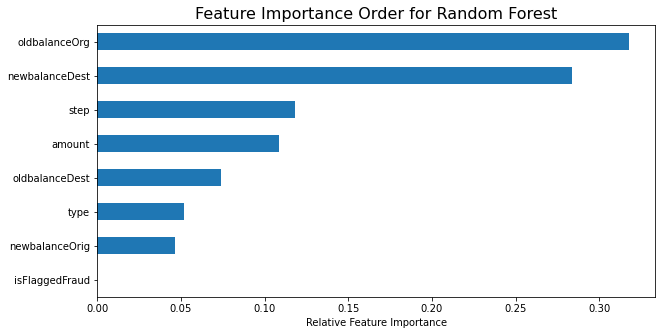

In [55]:
# Plot the important features - based on Random Forest
feat_importances = pd.Series(rf_model.feature_importances_, index=features.columns)
ax.set_ylabel('features', size = 16);
feat_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance');
plt.title('Feature Importance Order for Random Forest', size = 16);

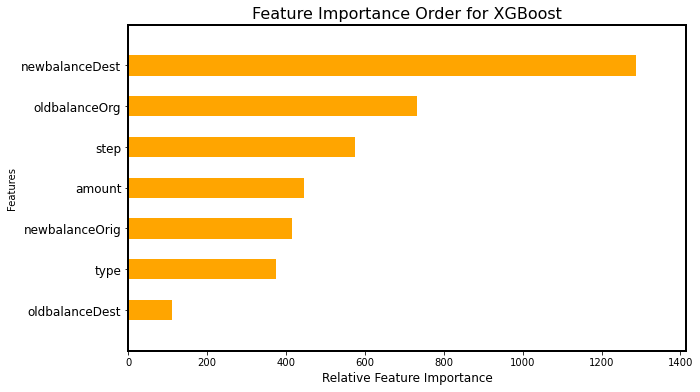

In [56]:
# Plot the important features - based on XGBOOST
from xgboost import plot_importance

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(xgb_model, height = 0.5, color = 'orange', grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)        
ax.set_xlabel('Relative Feature Importance', size=12);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Feature Importance Order for XGBoost', size = 16);

Each model gives different importance to the features. But **oldbalanceOrg** and **newbalanceDest** are the major indicators for both models.

## 6. Summary

### Accuracy results after iterations
We created a model that can predict fraud transactions. We started with four different classifiers and decided to proceed the two that have the better accuracy overall. They're XGBoost and RandomForest classifiers in this model. 

      (Data & Parameters)                                 (Accuracy)  XGBoost  RandomForest
      
      **Iteration 1**                                                            
    - Random Sample & default parameters                               86.44%     83.9%
    
      **Iteration 2** 
    - Random Sample & best parameters                                  85.59%     83.9%
    
      **Iteration 3**
    - Balanced data with SMOTE & best parameters                       99.66%    99.09% 
    
      **Iteration 4**
    - Random Safe trans. data and all Fraud data & best parameters     99.01%    93.65%
    
      **Iteration 5**
    - New data balanced with SMOTE & best parameters                    99.2%    94.15%


Performence has increased after five iterations and finally reached to **99%** accuracy with XGBoost Classifier and new Balanced Data


### Most Influential Features
- Most important features are senders balance before the transaction (**oldBalanceOrig**) and receivers balance after the transaction (**newBalanceDest**). 


### EDA Findings


- While secure transactions experience slowdowns on the 3rd and 4th days, as well as after the 16th day of each month, fraudulent transactions maintain a consistent pace. Particularly during the latter half of the month, the number of secure transactions diminishes significantly, whereas the count of fraudulent transactions remains constant.
- The overall proportion of fraud transactions among all transactions stands at 0.01%, while the proportion of the fraudulent amount is 0.1%.
- A certain level of periodicity is observable in the transaction count every 24 hours, but such a distinct pattern is not apparent in fraudulent transactions. The occurrence of fraudulent transactions maintains a nearly uniform frequency throughout each hour.
- audulent transactions are skewed towards lower amounts, with fewer instances involving larger sums. This distribution remains relatively stable.
- Fraudulent transactions encompass a wide range, spanning from 119 to 10 million. The majority of these instances involve smaller amounts. However, an intriguing upsurge, similar to secure transactions, occurs around the 1 million mark.
- Notably, there are 16 instances of fraudulent cases with an amount of '0'.
- Fraudulent activities exclusively take place within TRANSFER and CASH_OUT transactions, while DEBIT usage is notably secure.

